# Data Preparation

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]

# scaler = preprocessing.StandardScaler().fit(X_train)
# in_max_scaler = preprocessing.MinMaxScaler()

# X_train = preprocessing.normalize(X_train, norm='l2')

# m = np.mean(X_train, axis=0) # array([16.25, 26.25])
# std = np.std(X_train, axis=0) # array([17.45530005, 22.18529919])

# X_train = 0.5 * (np.tanh(0.01 * ((X_train - m) / std)) + 1)

predictor = Predictor()

# Current Decision Tree Classifier

In [2]:
#predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


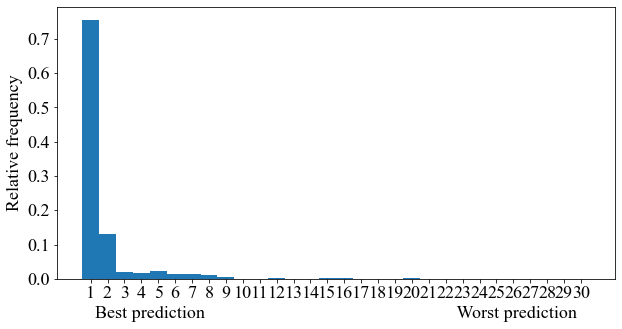

Best Accuracy:  0.7369282834818096
Top 3:  0.90625
Feature Importance:  [0.00765167 0.00999817 0.         0.07604696 0.00118178 0.
 0.00199262 0.02666374 0.         0.00118885 0.00502916 0.00276263
 0.00067951 0.         0.         0.         0.0084432  0.
 0.00090095 0.         0.38378471 0.08447781 0.11626393 0.04598196
 0.12499085 0.10196151]


In [4]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))
print("Feature Importance: ", clf.best_estimator_.feature_importances_)

# Random Forest

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


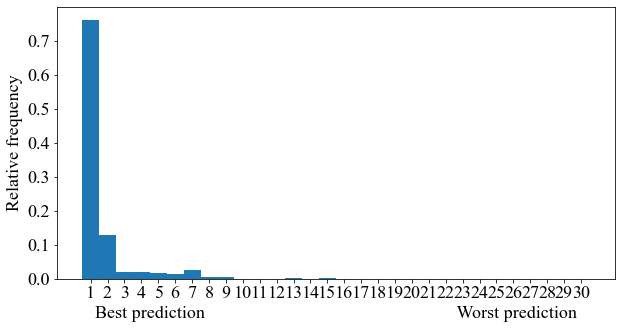

Best Accuracy:  0.7567013387746977
Top 3:  0.9095394736842105
Feature Importance:  [0.04350501 0.01110557 0.00038623 0.10464747 0.00708389 0.
 0.01192517 0.03464353 0.00097269 0.0049235  0.00635403 0.01401665
 0.001064   0.         0.00044037 0.0001897  0.01568184 0.
 0.00093896 0.00033609 0.17530268 0.09613122 0.08272953 0.13885685
 0.12061223 0.12815281]


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": list(range(1, 15, 4)),
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(1, 30, 5)),
        "min_samples_split": list(range(2, 20, 5)),
        "min_samples_leaf": list(range(2, 20, 5)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))
print("Feature Importance: ", clf.best_estimator_.feature_importances_)

# Nearest Neighbor

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


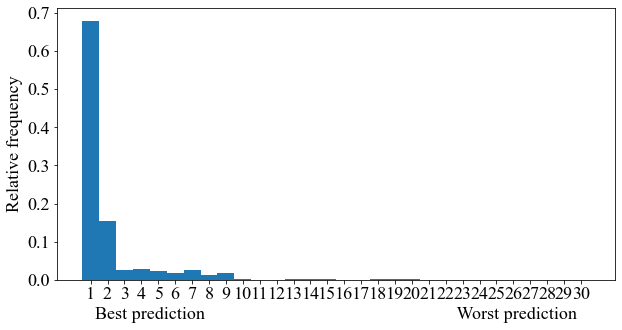

Best Accuracy:  0.6762827850495198
Top 3:  0.8585526315789473


In [6]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# SVM

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


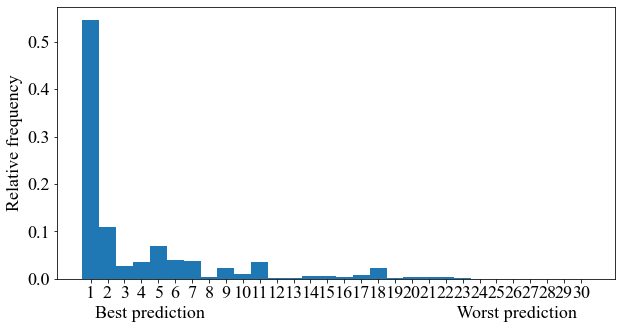

Best Accuracy:  0.5543298661225302
Top 3:  0.6842105263157895


In [7]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# Naive Bayes

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


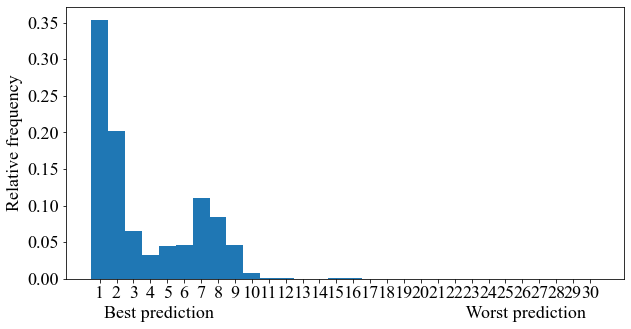

Best Accuracy:  0.29546359428656743
Top 3:  0.6217105263157895


In [8]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# SGD

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


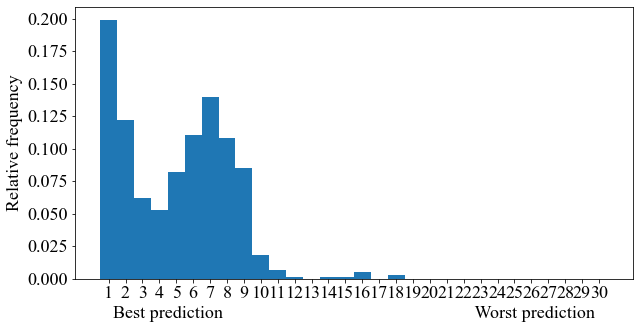

Best Accuracy:  0.22774846961628428
Top 3:  0.3832236842105263


In [9]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)

param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# GradientBoostingClassifier

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


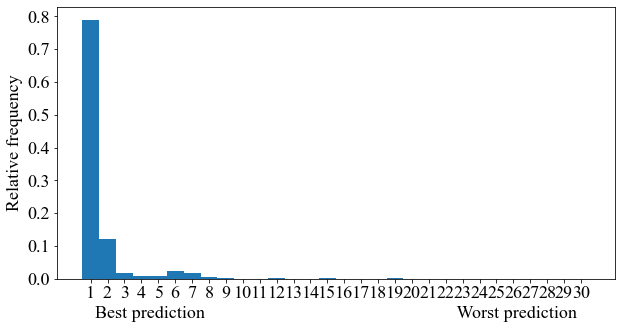

Best Accuracy:  0.754558801572687
Top 3:  0.9276315789473685


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# Multi Layer Perceptron

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/op

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

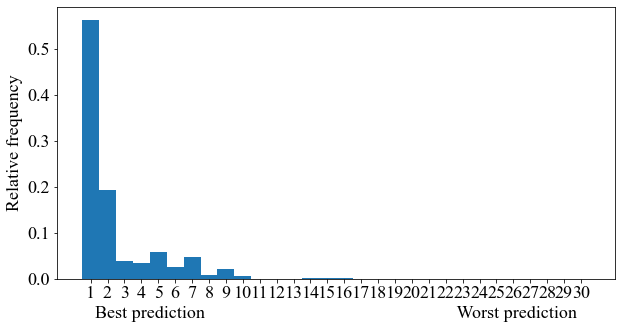

Best Accuracy:  0.6149629224107899
Top 3:  0.7927631578947368


In [11]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0)
param_grid = {
    "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100,)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["constant", "adaptive"],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
print("Top 3: ", (res.count(1) + res.count(2) + res.count(3)) / len(res))

# Debugging

In [ ]:
training_data, names_list, scores_list = utils.load_training_data()

In [12]:
X, y = zip(*training_data)
X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
len(non_zero_indices)

26

In [ ]:
for i in range(len(X)):
    if (X[i,4]>0):
        print(names_list[i], i)

In [ ]:
X[5]

In [ ]:

from qiskit import QuantumCircuit
from predictor.src import utils
filename="wstate_indep_qiskit_26"
qc = QuantumCircuit.from_qasm_file("comp_test_source/" +filename+".qasm")

In [ ]:
print(qc.count_ops())
print(utils.create_feature_dict("comp_test_source/" +filename+".qasm"))

In [ ]:
from predictor.src import utils
openqasm_gates_list = utils.get_openqasm_gates()
res_dct = {openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))}
print(res_dct)
res_dct = dict.fromkeys(openqasm_gates_list, 0)
print(res_dct)

In [ ]:
None + 2

In [ ]:
        non_zero_indices = []
        for i in range(len(X[0])):
            if sum(X[:, i]) > 0:
                non_zero_indices.append(i)
        X = X[:, non_zero_indices]